# COGS 118C - Final Project 

Github Link - https://github.com/Nikleon/AR-Modeling-EEG-for-SSVEP?fbclid=IwAR0OxwyNIEvDkNlPMaxw42d0T-1XO4rRX7l3vEbrW7nCJXYW9JztWoVhSE8

# Overview

This analysis is based on “A Comparison Study of CCA (Canonical Correlation Analysis) Based Methods for Detecting Steady-State Visual Evoked Potentials” Nakanishi et al. (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0140703) 

This study explores the CCA method that is most accurate in detecting SSVEPs(Steady-State Visual Evoked Potentials). We wanted to extend the publication to find a way to best transform the data that would lead to better classification accuracies.

# Names
- Niklas Sprute (A15105073)
- Shonak Shah (A13497236)
- Yi Chen (A14031292)
- Zijian Liu (A15723355) 

# Research Question

How does baseline correction using mean, detrended linear regression, detrended high pass and autoregressive (AR) modeling improve classification accuracy of single-trial SSVEPs (steady-state visually evoked potentials)? 

## Background and Prior Work

Our work is largely built upon the publication mentioned above (Nakanishi et al. 2015) (1st reference). This study performed a comparison of the existing CCA-based SSVEP detection methods using a 12-class SSVEP dataset recorded from 10 subjects in a simulated online BCI experiment. Classification accuracy and information transfer rate (ITR) were used for performance evaluation. The results suggest that individual calibration data can significantly improve the detection performance. Furthermore, the results showed that the combination method based on the standard CCA and the individual template based CCA (IT-CCA) achieved the highest performance.(This is taken from the Abstract of the paper)


Ten healthy subjects (9 males and 1 female, mean age: 28 years) with normal or corrected-to-normal vision participated in this study.
For each subject, the experiment consisted of 15 blocks. In each block, subjects were asked to gaze at one of the visual stimuli indicated by the stimulus program in a random order for 4s, and complete 12 trials corresponding to all 12 targets. At the beginning of each trial, a red square (see Fig 1A) appeared for 1s at the position of the target stimulus. Subjects were asked to shift their gaze to the target within the same 1s duration. After that, all stimuli started to flicker simultaneously for 4s on the monitor. To reduce eye movement artifacts, subjects were asked to avoid eye blinks during the stimulation period.


References:
1. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0140703
“A Comparison Study of CCA (Canonical Correlation Analysis) Based Methods for Detecting Steady-State Visual Evoked Potentials”

2. https://ieeexplore.ieee.org/document/5910588
“A comparison of minimum energy combination and canonical correlation analysis for SSVEP detection”

3. https://ieeexplore.ieee.org/abstract/document/6696023
“Canonical Correlation Approach to Common Spatial Patterns”


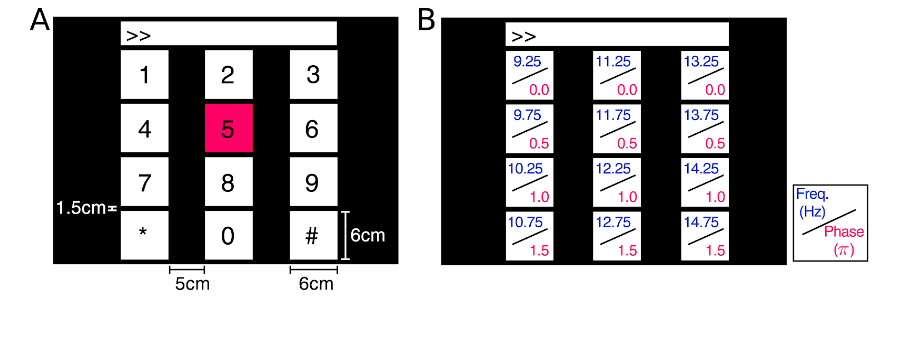

Their Methods and Findings: 

This study performed a comparison of the existing CCA-based SSVEP detection methods where classification accuracy and information transfer rate (ITR) was evaluated. The results suggest that individual calibration data can significantly improve the detection performance. Furthermore, the results showed that the combination method based on the standard CCA and the individual template based CCA (IT-CCA) achieved the highest performance.

Evaluating their analysis choices: 

The researchers wanted to evaluate different spatial filtering methods, such as canonical correlation analysis (CCA), minimum energy combination (MEC), and common spatial pattern (CSP), in SSVEP-based BCIs. They ended up choosing to explore CCA methods because they are robust, highly efficient, and have a simple implementation. The CCA methods that yielded the best classification accuracies were IT-CCA and a combination of CCA and IT-CCA with the standard CCA ranking at the bottom.

The researchers chose the standard CCA method because it performs canonical correlation analysis between multi-channel EEG signals and sinusoidal reference signals at stimulation frequencies. Then, the target frequencies based on the canonical correlation values can be identified. 

In previous studies like reference 2, CCA was compared to the same data versus MEC and the researchers found that CCA has lower deviation, higher accuracy and higher signal to noise ratio than MEC. This paper was published 4 years before the main paper we are basing our study off of so we believe this contributed to the researchers’ decision to focus their analysis through variations of CCA over MEC. In reference 3, they compared CCA to CSP and found that CCA has a better accuracy throughout their tests. This research was done at UCSD a year before the research paper we are basing our paper on. 

How it relates to our paper: 

This study explores the CCA method that is most accurate in detecting SSVEPs, which is similar to our research question because we are trying to determine the baseline correction that provides the highest accuracy. We wanted to extend the publication to find a way to best transform the data that would lead to better classification accuracies, so we obtained the study data from one of the researchers.




# Hypothesis
We hypothesize that out of all models(linear regression, high-pass filtering, and autoregressive modeling), AR modeling will have the highest accuracy of single-trial SSVEPs compared to the other methods. 


# Dataset
“.mat” file contains 4D-array with the following dimensions:
12 x 18 x 1114 x 15

12: number of target frequencies - from 9.25Hz to 14.75 Hz with 0.5Hz increment
18: number of channels - from 1 to 8: EEG channels (occipital area), 9: EEG channel (Fz)
1114: number of samples: first 74 samples (290 ms) baseline, then 1024 samples (4 sec) SSVEP stimuli, then 16 samples 16 samples (62 ms) after trial. 
15: number of trials for each frequency 



# Method Analysis

We apply different baseline correction techniques to determine which result in the best improvement of the SSVEP classifier. We mean subtract all the data in the beginning and then perform different transformations later on. These transformations are: 
- linear regression detrending 
- high pass filter detrending
- AR modeling 

Explanation of techniques used:

Mean-subtracted baseline - Method to get rid of noise during testing by taking the mean of data before stimulus presentation and subtracting it from the overall data. 
 
Linear regression - Method that utilizes the linear movement of the baseline when the mean of it is taken. Then, we detrended the baseline based on the linear regression to more accurately obtain the true signal.

Autoregressive (AR) modeling -  AR models are used for feature extraction and characterization of EEG signals. It represents the signal at each channel as a linear combination of the signal at previous time points in order to help us predict the true signal.

CCA - Canonical Correlation Analysis is used when presented data from a cross-covariance matrices. It finds the linear combinations of the different variables that maximize the correlation between the variables to further explore their relationship.


In [1]:
############ imports
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import periodogram, square, firwin
from scipy.stats import linregress
from scipy.io import loadmat
import scipy.stats

from sklearn.cross_decomposition import CCA  ### classification analysis
from statsmodels.tsa.arima_model import ARMA ### used for AR modeling

from fooof import FOOOF  ### libarary used to better visualize harmonics
from fooof.plts.spectra import plot_spectrum

import warnings # for AR so doesn't show all warnings when it breaks
warnings.filterwarnings('ignore')

# Data Cleaning
Here we discarded non-EEG data, created time vector for our analysis.

In [2]:
############# Loading and cleaning data
## DATA holds 5D array where each dimension is explained at bottom
    # the shape is (8,12,8,1114,15)
    # were only given subjects 4-12 that's why range is only 4 to 12
        ## 12 is omitted (see more in limitations)
DATA = np.array([
    loadmat(f'data/s{subject_id}.mat')['train'][:, :8, :, :] #Discard non-EEG-occipital channels (8+)
    for subject_id in range(4, 12)
])
num_subjects, num_targets, num_channels, N, num_trials = DATA.shape

### values were given as part of experiment (metadata declaration)
fs = 256
N_pre, N_dur, N_post = 74, 1024, 16
T_pre, T_dur, T_post = [n / fs for n in (N_pre, N_dur, N_post)]
t = np.array([x / fs for x in range(-N_pre, -N_pre + N)])

#Hacky was to get the right order of target frequencies (as they are in the data)
target_freqs = [9.25 + (x % 3) * 2 + int(x / 3) * 0.5 for x in range(num_targets)]

print(f"Subjects:          {num_subjects}")
print(f"Classes:           {num_targets}")
print(f"EEG Channels:      {num_channels}")
print(f"Time Samples:      {N}")
print(f"Trials per Class:  {num_trials}")

Subjects:          8
Classes:           12
EEG Channels:      8
Time Samples:      1114
Trials per Class:  15


# Data Analysis

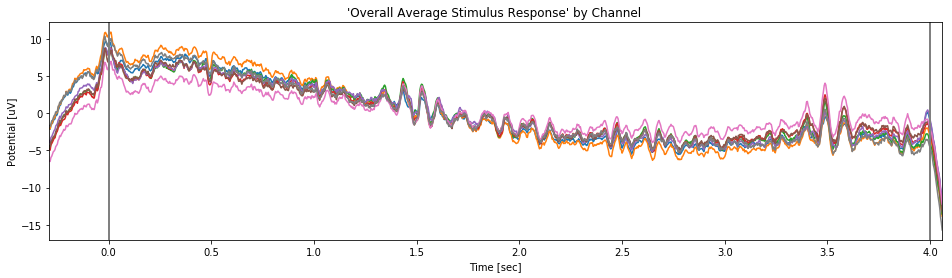

In [3]:
# Mean potential by all channels
plt.figure(figsize=(16, 4))
for ch in range(num_channels):
    y = DATA[:, :, ch, :, :].mean(axis=(0, 1, 3))
    plt.plot(np.array([x/fs for x in range(-N_pre, -N_pre + N)]), y - y.mean())
    plt.axvline(x=0, color='gray')
    plt.axvline(x=4, color='gray')
    plt.xlim(-T_pre, T_dur + T_post - 1/fs)
    plt.xlabel("Time [sec]"); plt.ylabel("Potential [uV]");
    plt.title("'Overall Average Stimulus Response' by Channel ");

data = DATA.mean(axis=2); #Evidently the channels picked up very similar signals. Merge them for simplicity.

Here we took the mean over all trials. Note that we splitted the graph in half to see more details

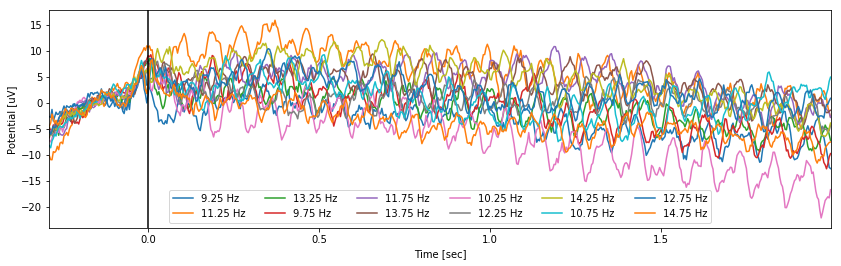

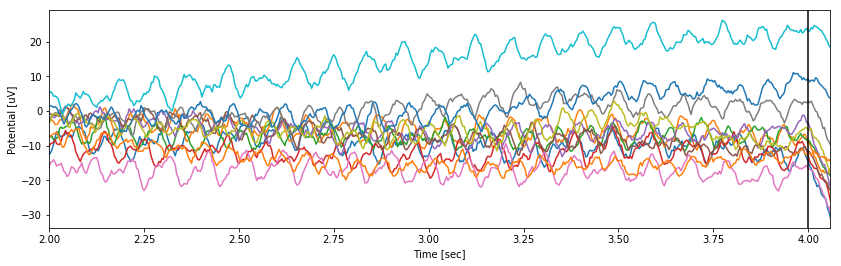

In [4]:
epoch_avgs = data.mean(axis=(0, 3)) #Average across same dimensions as above, but keep target frequencies seperate .

#Plot average response (mean-subtracted) by target frequency
plt.figure(figsize=(14, 4))
for ix, freq in enumerate(target_freqs[:]):
    mid_ix = int(N_pre + 2 * fs)
    plt.plot(t[:mid_ix], epoch_avgs[ix, :mid_ix] - epoch_avgs[ix, :N_pre].mean(axis=0), label=f"{freq} Hz")
plt.xlim(-T_pre, 2 - 1/fs)
plt.xlabel("Time [sec]"); plt.ylabel("Potential [uV]");
plt.legend(loc='lower center', ncol=6)
plt.axvline(x=0, color='black'); #Vertical line time-locked to start of flicker

#Same thing but split into two time domains to show more detail
plt.figure(figsize=(14, 4))
for ix, freq in enumerate(target_freqs):
    mid_ix = int(N_pre + 2 * fs)
    plt.plot(t[mid_ix:], epoch_avgs[ix, mid_ix:] - epoch_avgs[ix, :N_pre].mean(axis=0))
plt.xlim(2, T_dur + T_post - 1/fs)
plt.xlabel("Time [sec]"); plt.ylabel("Potential [uV]");
plt.axvline(x=T_dur, color='black'); #Vertical line time-locked to end of flicker

We  plotted periodogram, and generated FOOOF report. 

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 0 - 128 Hz                        
                                 Frequency Resolution is 0.25 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          1.3014, 1.7243                                          
                                                                                                  
                                       29 peaks were found:                                       
          

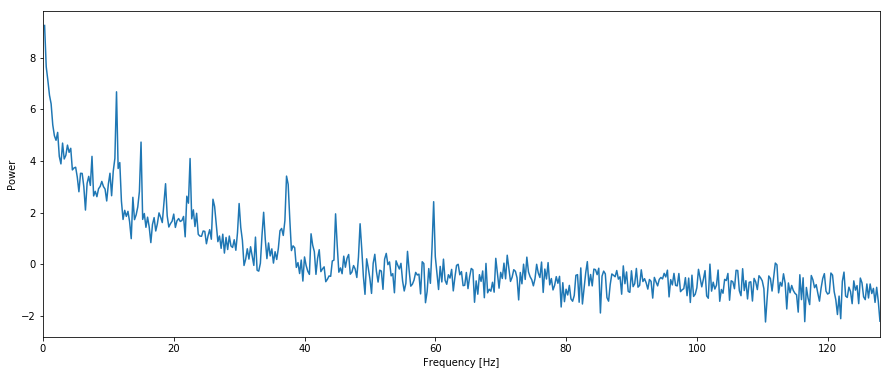

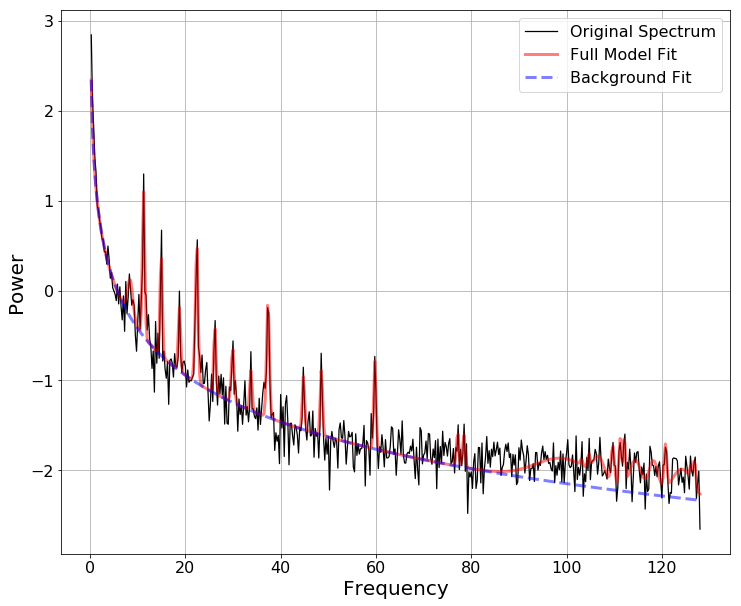

In [5]:
#Plot log-scale power spectrum for 11.25 Hz target response (excluding baseline and end)
f_trial, Pxx_trials = periodogram(data[:, :, N_pre:-N_post, :].mean(axis=3), fs=fs, axis=2)

plt.figure(figsize=(15, 6))
plt.xlim(0, fs/2)
plt.xlabel("Frequency [Hz]"); plt.ylabel("Power");

target_ix = 1

y = np.log(Pxx_trials[:, :, 1:]).mean(axis=0)
plt.plot(f_trial[1:], y[target_ix, :] - y.mean());

#Fit gaussian peaks the power spectrum to make it more evident that the dominant spikes occur at harmonic frequencies.
model = FOOOF(min_peak_amplitude=0.3, max_n_peaks=30)
model.report(f_trial[1:], Pxx_trials[:, target_ix, 1:].mean(axis=0))

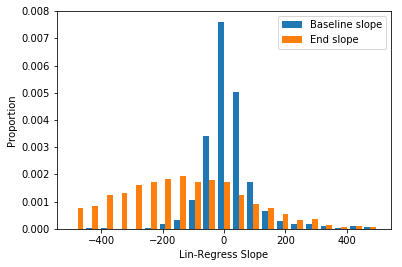

In [6]:
#Investigate whether the apparent slope of the baseline is consistent or a result of averaging
#Note: if you include subject 12, there is a significant bimodal peak in baseline slope above +450
l = []
m = []
for s_ix in range(num_subjects):
    for f_ix in range(num_targets):
        for tr_ix in range(num_trials):
            #Fit a line-of-best-fit to each baseline trial-wise and plot the slopes in a histogram
            l.append( linregress(x=t[:N_pre], y=data[s_ix, f_ix, :N_pre, tr_ix])[0] )
for s_ix in range(num_subjects):
    for f_ix in range(num_targets):
        for tr_ix in range(num_trials):
            #Same for end segments
            m.append( linregress(x=t[-N_post:], y=data[s_ix, f_ix, -N_post:, tr_ix])[0] )
plt.hist([l, m], bins=21, range=(-500, 500), density=True, label=["Baseline slope", "End slope"])
plt.xlabel("Lin-Regress Slope"); plt.ylabel("Proportion");
plt.legend();

This was the original plot that we generated, but the one above was chosen as the path forward due to the bimodal distribution in the original we elected to remove the outlier. This outlier was subject 12 and it helped to create a much better data for modeling. That's why the first cell has the range excluding the 12th subject.

We believe this is caused by subject 12 seeing the red box late and looking at the number very late in the trial, this created large positive slopes late into the trial (seen by the second peak in the bimodal distribution). Their removal also led to a baseline that was much closer to zero which is what is normally expected in SSVEPs. The late viewing might have led to increased potentials at the end of the data so the slope at the beginning was confounded and appeared much more positive than it should appear.

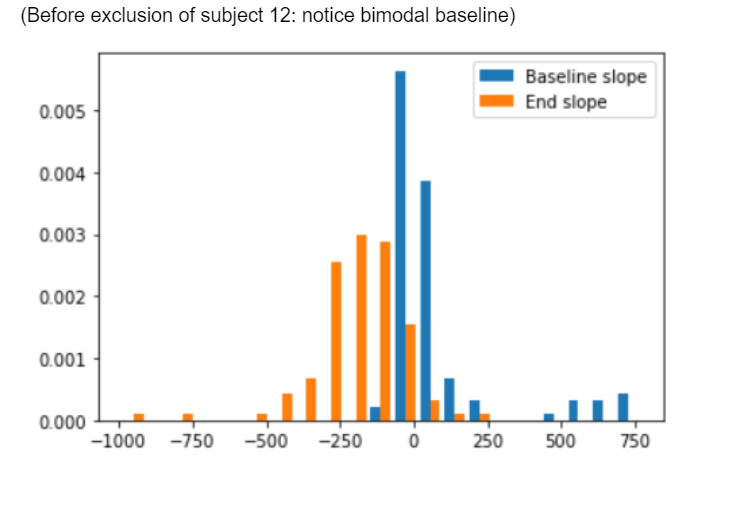


In [7]:
### DETRENDING + LINEAR-REGRESSION
# Filter out large trends (including the gradual drop-off in the average resembling neuron fatigue)
lowpass_cutoff = 1
lowpass_fir = firwin(3*fs+1, lowpass_cutoff, fs=fs, pass_zero=False)

AC_fir = firwin(3*fs+1, (59.5, 60.5), fs=fs, pass_zero = True) # Notch filter on 60 Hz

## Simulate single-trial low-reject filtering
s = []
for s_ix in range(num_subjects):
    f = []
    for f_ix in range(num_targets):
        ts = []
        for tr_ix in range(num_trials):
            #Important to mean-subtract the data first! Else there wil be major ringing artifacts around the epoch edges.
            y_temp = data[s_ix, f_ix, :, tr_ix] - data[s_ix, f_ix, :, tr_ix].mean()
            # Linear fit the baselines and subtract out the slopes (to prepare the baselines for AR modeling)
            slope, intercept, _, _, _ = linregress(x=t[:N_pre], y=y_temp[:N_pre])
            slope_corrected = y_temp - (np.pad(t[:N_pre] * slope, (0, N - N_pre), 'constant') + intercept)
            ts.append( np.convolve(   np.convolve(slope_corrected, lowpass_fir, 'same'),  AC_fir, 'same') ) #Filter epochs
        f.append( np.array(ts).T )
    s.append( np.array(f) )
data_detrended = np.array(s)
print(data_detrended.shape) ### to make sure the shape is consistent with before the detrending

(8, 12, 1114, 15)


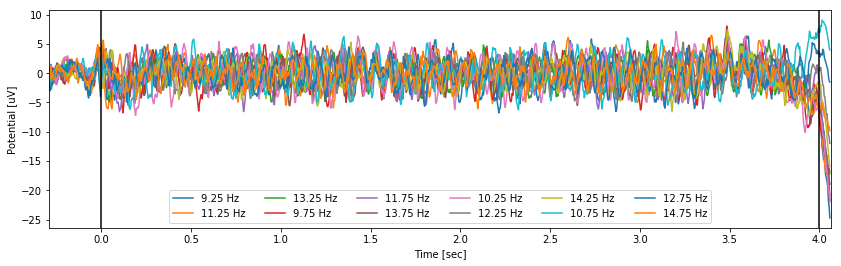

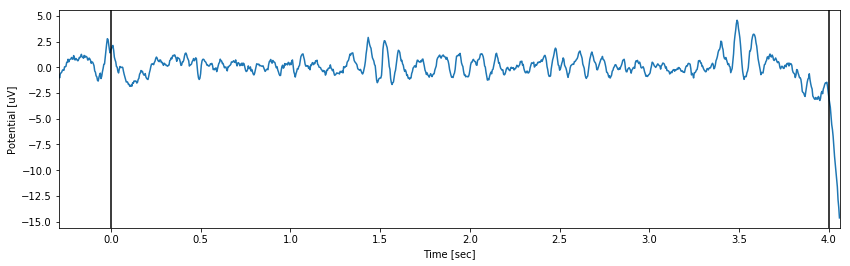

In [8]:
#Replot average response by target frequency (after baseline straightening and detrending + 60Hz notch)
pts = []
plt.figure(figsize=(14, 4))
for ix, freq in enumerate(target_freqs):
    plt.plot(t, data_detrended[:, ix, :, :].mean(axis=(0, 2)), label = f"{freq} Hz")
plt.xlim(-T_pre, T_dur + T_post)
plt.xlabel("Time [sec]"); plt.ylabel("Potential [uV]")
plt.legend(loc='lower center', ncol=6)
plt.axvline(x=0, color='black');
plt.axvline(x=T_dur, color='black');

#Overall average response - note the resonance patterns at 1.5 and 3.5 seconds!
plt.figure(figsize=(14, 4))
plt.plot(t, data_detrended.mean(axis=(0, 1, 3)) - data_detrended.mean(axis=(0, 1, 3)).mean(axis=0).mean());
plt.xlim(-T_pre, T_dur + T_post)
plt.xlabel("Time [sec]"); plt.ylabel("Potential [uV]")
plt.axvline(x=0, color='black');
plt.axvline(x=T_dur, color='black');

Notice the large downward trend at the end of the 4 seconds (this is addressed further in limiations).

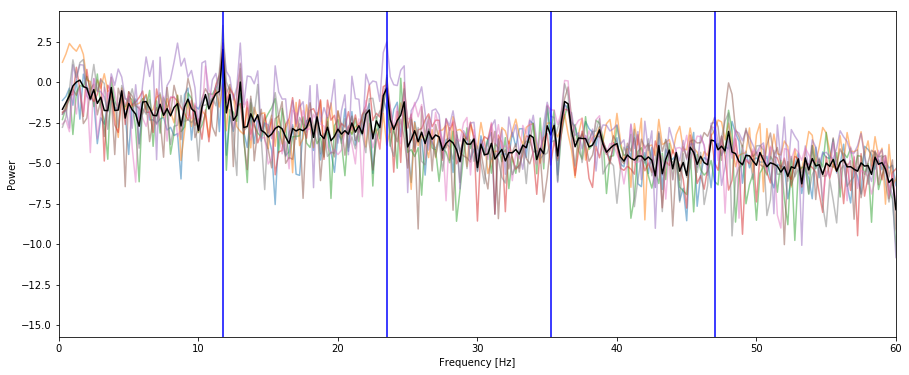

In [9]:
## Create periodogram
f_trial, Pxx_trials = periodogram(data_detrended[:, :, N_pre:-N_post, :].mean(axis=3), fs=fs, axis=2)

target_ix = 4 #11.75 Hz target

y = np.log(Pxx_trials[:, :, 1:])

plt.figure(figsize=(15, 6))
plt.xlim(0, fs/2)
for subject_ix in range(num_subjects):
    plt.plot(f_trial[1:], y[subject_ix, target_ix, :], alpha=0.5);
plt.plot(f_trial[1:], y[:, target_ix, :].mean(axis=0), 'black');
plt.xlabel("Frequency [Hz]"); plt.ylabel("Power");
plt.xlim(0, 60)

#Demonstrate alignment to integer harmonics - concept later taken advantage of in creating the CCA template
h = 9.25 + (target_ix % 3) * 2 + int(target_ix / 3) * 0.5
for harmonic in range(4):
    plt.axvline(x=h*(harmonic+1), color='blue')

'\nharmonic and subharmonic components are a natural consequence \nof the nonlinear properties of neuronal populations and the \nresonant properties of the modeled network.\n\nhttps://www.ncbi.nlm.nih.gov/pmc/articles/PMC5187367/\n'

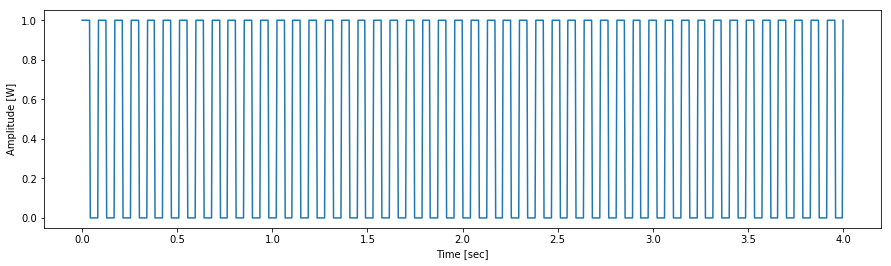

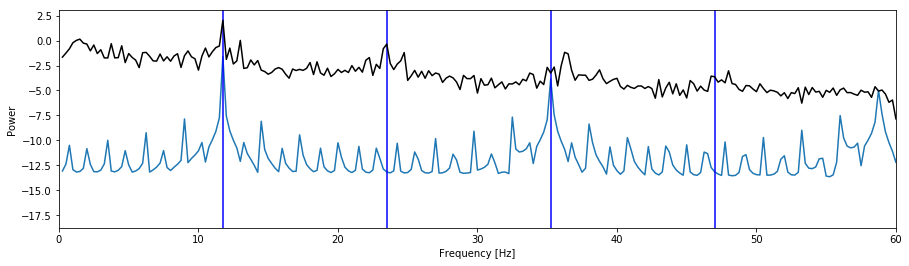

In [10]:
#But why are there harmonics? Simple answer: the stimulus is a square wave, whose Fourier series spikes at 2k+1 intervals

#Example params
ex_hz = 9.25 + (target_ix % 3) * 2 + int(target_ix / 3) * 0.5
ex_fs = 256
ex_T  = 4

#Prepare a square wave to match one epoch
ex_t_scaled = np.linspace(0, 2 * np.pi * (ex_hz * ex_T), ex_fs * ex_T)
ex_y = square(ex_t_scaled) / 2 + 0.5
ex_t = ex_t_scaled / (2 * np.pi * ex_hz)
plt.figure(figsize=(15, 4))
plt.plot(ex_t, ex_y)
plt.xlabel("Time [sec]"); plt.ylabel("Amplitude [W]");

#DFT the square wave
ex_f, ex_Pxx = periodogram(ex_y, fs=ex_fs, scaling='spectrum')
plt.figure(figsize=(15, 4))
plt.plot(ex_f[1:], np.log(ex_Pxx[1:]));
plt.xlim(0, 60)

#Plot harmonics
for harmonic in range(4):
    plt.axvline(x=ex_hz*(harmonic+1), color='blue')

plt.plot(f_trial[1:], y[:, target_ix, :].mean(axis=0), 'black');
plt.xlabel("Frequency [Hz]"); plt.ylabel("Power");

#More accurate answer (accounting for all spikes):
'''
harmonic and subharmonic components are a natural consequence 
of the nonlinear properties of neuronal populations and the 
resonant properties of the modeled network.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5187367/
'''

Square wave above is used to give a better visualization of the signal changes as the light flashes at different frequencies. So when the wave is at 1.0, means the light is flashing and 0 means it isn't.

In [11]:
#Brute-force computation of result statistics
num_harmonics = 2 # for CCA template
APPS = [(False, False, False), (True, False, False), (False, True, False)] #Models to run (detrend, highpass, AR)
#Note: the baseline segments often are not long enough to include an entire dominant oscillation and so AR is unstable
#AR works qualitatively but it fails too often to gather quantitative statistics (future: get longer baselines)

def canonical_correlation(x, y): #### performs CCA classification analysis
    X_c, Y_c = CCA(n_components=1).fit_transform(x, y)
    return scipy.stats.pearsonr(X_c.flatten(), Y_c.flatten())[0]

#Prepare CCA template using vector of sinusoids at harmonic frequencies
Y = []
for stim_freq in target_freqs:
    Y_n = []
    for h in range(num_harmonics):
        Y_n.append( np.sin(2 * np.pi * (h+1) * stim_freq * t) )
        Y_n.append( np.cos(2 * np.pi * (h+1) * stim_freq * t) )
    Y.append( np.array(Y_n) )

#Matrix to hold prediction success results
res = np.zeros((3, num_subjects, num_targets, num_trials))
for app_ix, app in enumerate(APPS):
    detrend, highpass, AR = app
    for subject_ix in range(num_subjects):
        print(f'[DT:{detrend}, HP:{highpass}, AR:{AR}] Sbj.{subject_ix}...\t', end='')
        for freq_ix in range(num_targets):
            for trial_ix in range(num_trials):
                X_hat = DATA[subject_ix, freq_ix, :, :, trial_ix]
                
                for ch_ix in range(num_channels):
                    X_hat[ch_ix] -= X_hat[ch_ix].mean() #Mean-subtract
                
                #Split the epoch into 8 chunks, linear fit the chunks and subtract out the linear trends
                if detrend:
                    num_chunks = 8
                    for ch_ix in range(num_channels):
                        for chunk in range(num_chunks):
                            start, end = int(N_dur * (chunk / num_chunks)), int(N_dur * ((chunk+1) / num_chunks)) - 1
                            slope, intercept, _, _, _ = linregress(x=t[start:end], y=X_hat[ch_ix, start:end])
                            X_hat[ch_ix] -= (np.pad(t[start:end] * slope, (N_pre + start, N_dur + N_post - end), 
                                                    'constant') + intercept)

                #Instead of segment-wise linear detrending, treat the trend as a low frequency component 
                   # and filter it out
                if highpass:
                    for ch_ix in range(num_channels):
                        X_hat[ch_ix] = np.convolve(X_hat[ch_ix], lowpass_fir, 'same')
                        X_hat[ch_ix] = np.convolve(X_hat[ch_ix], AC_fir, 'same')
                
                #Pure-AR model (10 step) of the baseline
                #Use a stride of 2 to ease computation
                if AR:
                    X_hat = X_hat.mean(axis=0)
                    slope, intercept, _, _, _ = linregress(x=t[:N_pre], y=X_hat[:N_pre])
                    X_hat -= (np.pad(t[:N_pre] * slope, (0, N - N_pre), 'constant') + intercept)
                    model = ARIMA(X_hat[:N_pre:2], order=(10, 0, 0)).fit(trend='nc')
                    forecast, _, _ = model.forecast(int((N_dur + N_post)/2))
                    X_hat -= np.pad(np.repeat(forecast, 2), (N_pre, 0), 'constant')

                #Ultimately, the predicted target frequency is the one that achieves the maximum canonical correlation, 
                   #rho
                rho = [canonical_correlation(Y[n].T, X_hat.T) for n in range(num_targets)]
                res[app_ix, subject_ix, freq_ix, trial_ix] = int(np.argmax(rho) == freq_ix)
        print('DONE')

[DT:False, HP:False, AR:False] Sbj.0...	DONE
[DT:False, HP:False, AR:False] Sbj.1...	DONE
[DT:False, HP:False, AR:False] Sbj.2...	DONE
[DT:False, HP:False, AR:False] Sbj.3...	DONE
[DT:False, HP:False, AR:False] Sbj.4...	DONE
[DT:False, HP:False, AR:False] Sbj.5...	DONE
[DT:False, HP:False, AR:False] Sbj.6...	DONE
[DT:False, HP:False, AR:False] Sbj.7...	DONE
[DT:True, HP:False, AR:False] Sbj.0...	DONE
[DT:True, HP:False, AR:False] Sbj.1...	DONE
[DT:True, HP:False, AR:False] Sbj.2...	DONE
[DT:True, HP:False, AR:False] Sbj.3...	DONE
[DT:True, HP:False, AR:False] Sbj.4...	DONE
[DT:True, HP:False, AR:False] Sbj.5...	DONE
[DT:True, HP:False, AR:False] Sbj.6...	DONE
[DT:True, HP:False, AR:False] Sbj.7...	DONE
[DT:False, HP:True, AR:False] Sbj.0...	DONE
[DT:False, HP:True, AR:False] Sbj.1...	DONE
[DT:False, HP:True, AR:False] Sbj.2...	DONE
[DT:False, HP:True, AR:False] Sbj.3...	DONE
[DT:False, HP:True, AR:False] Sbj.4...	DONE
[DT:False, HP:True, AR:False] Sbj.5...	DONE
[DT:False, HP:True, AR:F

Notice that AR remains false in all of these tests, this is since AR consistently breaks when used in the code. This is further explained in the conclusion and limitations of our study.

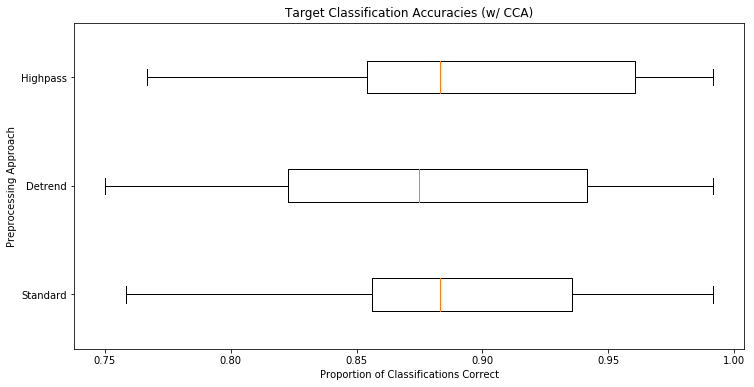

In [12]:
#### perform CCA accuracy tests

boxes = []; labels = []
### uses APPS to determine which transformations are done to use for CCA
for app_ix, app in enumerate(APPS):
    detrend, highpass, AR = app
    boxes.append([
        res[app_ix, :, f_ix, :].mean()
        for f_ix in range(num_targets)
    ])
    labels.append( f"{('','Highpass')[highpass]}{('','Linear')[detrend]}{('',' + AR')[AR]}{('','Standard')[not (detrend or highpass)]}" )

plt.figure(figsize=(12, 6))
plt.title("Target Classification Accuracies (w/ CCA)")
plt.xlabel("Proportion of Classifications Correct"); plt.ylabel("Preprocessing Approach")
plt.boxplot(boxes, labels=labels, vert=False);

# Note: Classification accuracy decreases with target frequency

Standard is just mean-subtracted baseline without any other transformations. The other two are transformations done on the data after the mean-subtracted baseline.

# Limitations
- AR had issues with working due to the small baselines we were given in the data. This is due to AR not being specifically made for oscillating signals but for forecasting any general time series. The smaller baselines lead to a smaller amount of points to work with that doesn't allow us to capture a full cycle of the dominant frequency leading to AR modeling the series as either constantly increasing/decreasing. This creates an unstable signal that breaks the forecast modeling.  

- We are still unsure what caused the large spikes at exactly 1.5 seconds and 3.5 seconds. 
- We are unsure of what exactly caused the steep drop at the end after 4 seconds. We speculate that this happens because the stimulus disappeared, and perhaps a blank screen caused the drop. 
- Another ambiguity is that we are not sure when exactly the subjects started to gaze at the visual stimulus. The actual stimulus onset was not accurate since there could be a delay between the EEG signals and event marker, due to differences across trials and subjects. We originally wanted to use the baseline activity before stimulus onset to predict the EEG activity, however, because the data baseline we have was a short period, (goes from 290ms before the onset of the visual stimulus), we were not able to predict the EEG activity with a high accuracy. That’s why we compared those baseline removal methods mentioned earlier in improving the SSVEP signal.

# Conclusion
We conclude that detrending with high pass has the highest Target Classification Accuracies. 

The AR rates are not shown in classification accuracies as the forecasting model breaks so its accuracy would be minimal at best if kept in. The reason that AR isnt working is because we dont have long enough baselines to capture a full cycle of the dominant oscillations. Only a small fraction of the data was forecasted before the model became too unstable leading to a small accuracy when CCA was done. So we concluded that on this dataset, the AR is not the best technique to model in the data for SSVEP and BCI. However, if in the future, we could do this experiment with greater baseline time lengths on both sides of the 4 seconds, it'll allow us to better break through our current limitations to better understanding SSVEP modeling. 


# Contributions

Yi Chen (Joylynn)- Research Question, Hypothesis, Parameters, Background Research, Overview, Limitations

Niklas Sprute- Research Question, Hypotheses, Method Analysis, Overview, Conclusion, Connected us to lab we obtained data from

Zijian Liu (Connor) - Research Question, Hypotheses, Method Analysis, Conclusion, Limitations

Shonk Shah - Research Question, Parameters, Background Research, Limitations, Overview, Presentation